In [1]:
from sklearn.cluster import KMeans
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv
/kaggle/input/metropt-3-dataset/Data Description_Metro.pdf


In [2]:
#%%timeit
# Reading in first 100k rows of MetroPT3 Air Compressor data
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', engine='pyarrow')
metro_df_large.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0   0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1  10 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2  20 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3  30 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4  40 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  
0              1.0        1.0              1.0  
1              1.0        1.0              1.0  
2              1.0        1.0              1.0  
3              1.0        1.0              1.0  
4              1.0        1.0              1.0

Attribute Information:
The dataset consists of 15169480 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
* #1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	
* #1 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00
* #3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00
* #4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

In [3]:
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0                    1516948 non-null  int64         
 1   timestamp        1516948 non-null  datetime64[ns]
 2   TP2              1516948 non-null  float64       
 3   TP3              1516948 non-null  float64       
 4   H1               1516948 non-null  float64       
 5   DV_pressure      1516948 non-null  float64       
 6   Reservoirs       1516948 non-null  float64       
 7   Oil_temperature  1516948 non-null  float64       
 8   Motor_current    1516948 non-null  float64       
 9   COMP             1516948 non-null  float64       
 10  DV_eletric       1516948 non-null  float64       
 11  Towers           1516948 non-null  float64       
 12  MPG              1516948 non-null  float64       
 13  LPS              1516948 non-null  float64       
 14  Pr

In [4]:
metro_df_large.describe()

TP2           TP3            H1   DV_pressure  \
count  1.516948e+06  1.516948e+06  1.516948e+06  1.516948e+06  1.516948e+06   
mean   7.584735e+06  1.367826e+00  8.984611e+00  7.568155e+00  5.595619e-02   
std    4.379053e+06  3.250930e+00  6.390951e-01  3.333200e+00  3.824015e-01   
min    0.000000e+00 -3.200000e-02  7.300000e-01 -3.600000e-02 -3.200000e-02   
25%    3.792368e+06 -1.400000e-02  8.492000e+00  8.254000e+00 -2.200000e-02   
50%    7.584735e+06 -1.200000e-02  8.960000e+00  8.784000e+00 -2.000000e-02   
75%    1.137710e+07 -1.000000e-02  9.492000e+00  9.374000e+00 -1.800000e-02   
max    1.516947e+07  1.067600e+01  1.030200e+01  1.028800e+01  9.844000e+00   

         Reservoirs  Oil_temperature  Motor_current          COMP  \
count  1.516948e+06     1.516948e+06   1.516948e+06  1.516948e+06   
mean   8.985233e+00     6.264418e+01   2.050171e+00  8.369568e-01   
std    6.383070e-01     6.516261e+00   2.302053e+00  3.694052e-01   
min    7.120000e-01     1.540000e+01   2.000000e-02  0.000000e+00   
25%    8.494000e+00     5.777500e+01   4.000000e-02  1.000000e+00   
50%    8.960000e+00     6.270000e+01   4.500000e-02  1.000000e+00   
75%    9.492000e+00     6.725000e+01   3.807500e+00  1.000000e+00   
max    1.030000e+01     8.905000e+01   9.295000e+00  1.000000e+00   

         DV_eletric        Towers           MPG           LPS  \
count  1.516948e+06  1.516948e+06  1.516948e+06  1.516948e+06   
mean   1.606106e-01  9.198483e-01  8.326640e-01  3.420025e-03   
std    3.671716e-01  2.715280e-01  3.732757e-01  5.838091e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
50%    0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
75%    0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       Pressure_switch     Oil_level  Caudal_impulses  
count     1.516948e+06  1.516948e+06     1.516948e+06  
mean      9.914368e-01  9.041556e-01     9.371066e-01  
std       9.214078e-02  2.943779e-01     2.427712e-01  
min       0.000000e+00  0.000000e+00     0.000000e+00  
25%       1.000000e+00  1.000000e+00     1.000000e+00  
50%       1.000000e+00  1.000000e+00     1.000000e+00  
75%       1.000000e+00  1.000000e+00     1.000000e+00  
max       1.000000e+00  1.000000e+00     1.000000e+00

In [5]:
print(metro_df_large.Caudal_impulses.value_counts())

1.0    1421542
0.0      95406
Name: Caudal_impulses, dtype: int64


In [6]:
metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)
metro_df_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   TP2              1516948 non-null  float64
 1   TP3              1516948 non-null  float64
 2   H1               1516948 non-null  float64
 3   DV_pressure      1516948 non-null  float64
 4   Reservoirs       1516948 non-null  float64
 5   Oil_temperature  1516948 non-null  float64
 6   Motor_current    1516948 non-null  float64
 7   COMP             1516948 non-null  float64
 8   DV_eletric       1516948 non-null  float64
 9   Towers           1516948 non-null  float64
 10  MPG              1516948 non-null  float64
 11  LPS              1516948 non-null  float64
 12  Pressure_switch  1516948 non-null  float64
 13  Oil_level        1516948 non-null  float64
 14  Caudal_impulses  1516948 non-null  float64
dtypes: float64(15)
memory usage: 173.6 MB


In [7]:
# Set up KMeans
kmeans = KMeans(n_clusters=3)

# Fit the model to the data
kmeans.fit(metro_df_clustering)

# Predict the clusters
metro_df_large['cluster'] = kmeans.predict(metro_df_clustering)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
metro_df_large.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0   0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1  10 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2  20 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3  30 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4  40 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  cluster  
0              1.0        1.0              1.0        2  
1              1.0        1.0              1.0        2  
2              1.0        1.0              1.0        2  
3              1.0        1.0              1.0        2  
4              1.0        1.0              1.0        2

In [9]:
metro_df_large.cluster.value_counts()

1    652185
2    643419
0    221344
Name: cluster, dtype: int64

In [10]:
cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()
cluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()
cluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()

cluster_0_df.head()


timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
2487  24870 2020-02-01 06:50:49  8.690  8.272 -0.024       -0.022       8.268   
2488  24880 2020-02-01 06:50:59  8.928  8.518 -0.022       -0.022       8.516   
2489  24890 2020-02-01 06:51:09  9.172  8.772 -0.022       -0.022       8.772   
2490  24900 2020-02-01 06:51:19  9.248  8.918 -0.018       -0.022       8.916   
2491  24910 2020-02-01 06:51:29  9.458  9.134 -0.016       -0.022       9.132   

      Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
2487           54.200         5.7525   0.0         1.0     1.0  0.0  0.0   
2488           54.075         5.9425   0.0         1.0     1.0  0.0  0.0   
2489           54.125         5.8600   0.0         1.0     1.0  0.0  0.0   
2490           54.150         5.9150   0.0         1.0     0.0  0.0  0.0   
2491           54.175         5.9550   0.0         1.0     0.0  0.0  0.0   

      Pressure_switch  Oil_level  Caudal_impulses  cluster  
2487              1.0        1.0              1.0        0  
2488              1.0        1.0              1.0        0  
2489              1.0        1.0              1.0        0  
2490              1.0        1.0              1.0        0  
2491              1.0        1.0              1.0        0

In [11]:
cluster_0_df.describe()

TP2            TP3             H1  \
count  2.213440e+05  221344.000000  221344.000000  221344.000000   
mean   8.358506e+06       8.877062       8.920192      -0.001003   
std    3.712809e+06       1.356362       0.786903       0.229211   
min    2.487000e+04      -0.014000       0.886000      -0.036000   
25%    5.289538e+06       8.390000       8.404000      -0.014000   
50%    8.937825e+06       9.042000       8.874000      -0.012000   
75%    1.103028e+07       9.804000       9.554000      -0.008000   
max    1.516871e+07      10.676000      10.288000       8.778000   

         DV_pressure     Reservoirs  Oil_temperature  Motor_current  \
count  221344.000000  221344.000000     221344.00000  221344.000000   
mean        0.480094       8.919212         67.56107       5.792158   
std         0.848711       0.785670          6.63730       0.323291   
min        -0.030000       0.866000         52.40000       0.025000   
25%        -0.020000       8.404000         62.75000       5.575000   
50%        -0.016000       8.874000         67.20000       5.845000   
75%         0.716000       9.552000         73.70000       6.037500   
max         9.844000      10.290000         89.05000       6.402500   

                COMP     DV_eletric         Towers            MPG  \
count  221344.000000  221344.000000  221344.000000  221344.000000   
mean        0.003221       0.980483       0.525702       0.002675   
std         0.056665       0.138334       0.499340       0.051647   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       1.000000       0.000000   
75%         0.000000       1.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 LPS  Pressure_switch      Oil_level  Caudal_impulses  \
count  221344.000000    221344.000000  221344.000000    221344.000000   
mean        0.009492         0.976060       0.909706         0.930190   
std         0.096964         0.152863       0.286603         0.254827   
min         0.000000         0.000000       0.000000         0.000000   
25%         0.000000         1.000000       1.000000         1.000000   
50%         0.000000         1.000000       1.000000         1.000000   
75%         0.000000         1.000000       1.000000         1.000000   
max         1.000000         1.000000       1.000000         1.000000   

        cluster  
count  221344.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

In [12]:
cluster_1_df.describe()

TP2            TP3             H1  \
count  6.521850e+05  652185.00000  652185.000000  652185.000000   
mean   9.647777e+06      -0.00539       9.266117       9.252105   
std    3.818356e+06       0.16738       0.542813       0.559471   
min    4.799000e+04      -0.03200       1.446000      -0.008000   
25%    7.492690e+06      -0.01400       8.866000       8.852000   
50%    1.047371e+07      -0.01200       9.340000       9.328000   
75%    1.274067e+07      -0.01000       9.712000       9.700000   
max    1.516923e+07       7.59200      10.302000      10.288000   

         DV_pressure     Reservoirs  Oil_temperature  Motor_current  \
count  652185.000000  652185.000000    652185.000000  652185.000000   
mean       -0.014008       9.266743        66.818027       2.272390   
std         0.131175       0.541573         3.214851       1.830889   
min        -0.032000       1.442000        60.875000       0.020000   
25%        -0.022000       8.868000        64.250000       0.042500   
50%        -0.020000       9.342000        66.550000       3.690000   
75%        -0.018000       9.712000        68.950000       3.777500   
max         6.282000      10.300000        82.575000       9.295000   

                COMP     DV_eletric         Towers            MPG  \
count  652185.000000  652185.000000  652185.000000  652185.000000   
mean        0.992356       0.010359       0.992665       0.982563   
std         0.087093       0.101251       0.085332       0.130892   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       1.000000       1.000000   
50%         1.000000       0.000000       1.000000       1.000000   
75%         1.000000       0.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 LPS  Pressure_switch      Oil_level  Caudal_impulses  \
count  652185.000000    652185.000000  652185.000000    652185.000000   
mean        0.000046         0.991574       0.845188         0.920178   
std         0.006782         0.091403       0.361726         0.271018   
min         0.000000         0.000000       0.000000         0.000000   
25%         0.000000         1.000000       1.000000         1.000000   
50%         0.000000         1.000000       1.000000         1.000000   
75%         0.000000         1.000000       1.000000         1.000000   
max         1.000000         1.000000       1.000000         1.000000   

        cluster  
count  652185.0  
mean        1.0  
std         0.0  
min         1.0  
25%         1.0  
50%         1.0  
75%         1.0  
max         1.0

In [13]:
cluster_2_df.describe()

TP2            TP3             H1  \
count  6.434190e+05  643419.000000  643419.000000  643419.000000   
mean   5.227399e+06       0.176482       8.721430       8.465145   
std    3.951269e+06       1.235475       0.547965       1.571746   
min    0.000000e+00      -0.032000       0.730000      -0.034000   
25%    1.787405e+06      -0.014000       8.336000       8.308000   
50%    4.714470e+06      -0.014000       8.646000       8.622000   
75%    7.192585e+06      -0.012000       9.056000       9.032000   
max    1.516947e+07      10.652000      10.248000      10.250000   

         DV_pressure     Reservoirs  Oil_temperature  Motor_current  \
count  643419.000000  643419.000000    643419.000000  643419.000000   
mean       -0.019035       8.722601        56.722002       0.537635   
std         0.083979       0.547847         3.664803       1.380418   
min        -0.032000       0.712000        15.400000       0.020000   
25%        -0.024000       8.336000        54.600000       0.040000   
50%        -0.022000       8.648000        57.200000       0.042500   
75%        -0.020000       9.058000        59.575000       0.042500   
max         7.558000      10.244000        62.550000       9.175000   

                COMP     DV_eletric         Towers            MPG  \
count  643419.000000  643419.000000  643419.000000  643419.000000   
mean        0.966255       0.030863       0.981631       0.966249   
std         0.180572       0.172947       0.134282       0.180588   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       1.000000       1.000000   
50%         1.000000       0.000000       1.000000       1.000000   
75%         1.000000       0.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 LPS  Pressure_switch      Oil_level  Caudal_impulses  \
count  643419.000000    643419.000000  643419.000000    643419.000000   
mean        0.004751         0.996587       0.962017         0.956646   
std         0.068765         0.058321       0.191155         0.203654   
min         0.000000         0.000000       0.000000         0.000000   
25%         0.000000         1.000000       1.000000         1.000000   
50%         0.000000         1.000000       1.000000         1.000000   
75%         0.000000         1.000000       1.000000         1.000000   
max         1.000000         1.000000       1.000000         1.000000   

        cluster  
count  643419.0  
mean        2.0  
std         0.0  
min         2.0  
25%         2.0  
50%         2.0  
75%         2.0  
max         2.0

<Axes: title={'center': 'Cluster 2'}, xlabel='TP3', ylabel='TP2'>

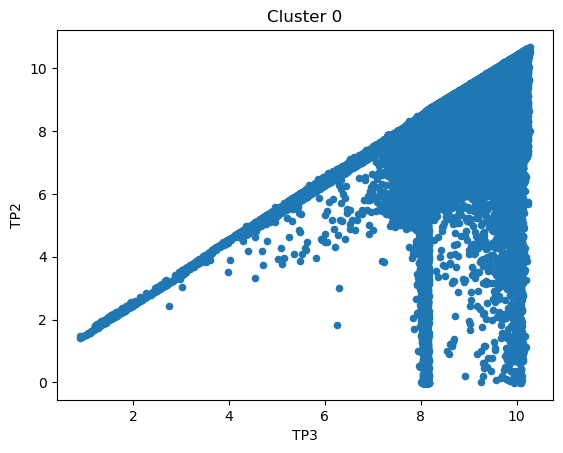

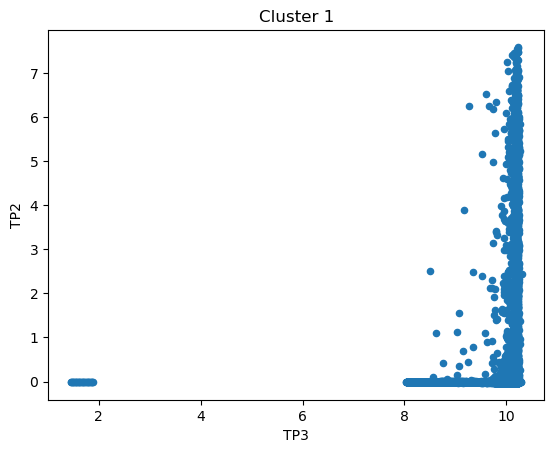

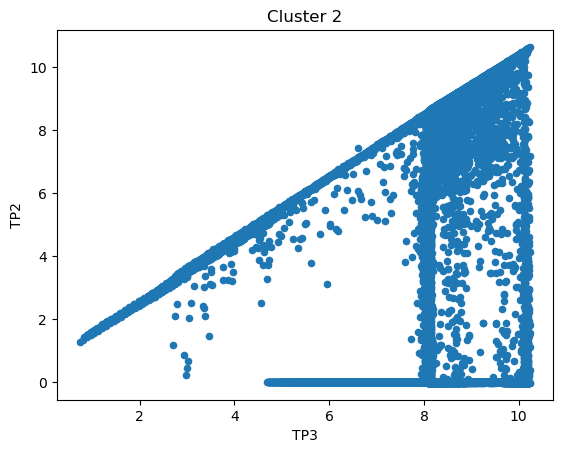

In [14]:
cluster_0_df.plot(x='TP3',y='TP2', kind='scatter', title='Cluster 0')
cluster_1_df.plot(x='TP3',y='TP2', kind='scatter', title='Cluster 1')
cluster_2_df.plot(x='TP3',y='TP2', kind='scatter', title='Cluster 2')

In [15]:
metro_df_large['oil_rolling'] = metro_df_large['Oil_temperature'].rolling(6).mean()
metro_df_large.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0   0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1  10 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2  20 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3  30 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4  40 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  cluster  oil_rolling  
0              1.0        1.0              1.0        2          NaN  
1              1.0        1.0              1.0        2          NaN  
2              1.0        1.0              1.0        2          NaN  
3              1.0        1.0              1.0        2          NaN  
4              1.0        1.0              1.0        2          NaN

In [16]:
metro_sample = metro_df_large.sample(frac=0.1, random_state=17)

In [17]:
fig = px.scatter_3d(metro_sample, title='Air Compressor Clusters',x='Motor_current',y='Oil_temperature', z='DV_pressure', symbol='cluster',size_max=2, color='cluster', opacity=0.5, width=1000, height=800)
fig.update_layout(title_x=0.5, showlegend=False, coloraxis_showscale=False)
fig.show()

In [18]:
"""fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


ax.scatter(data=metro_sample, xs='Motor_current',ys='Oil_temperature', zs='DV_pressure', c='cluster')"""

"fig = plt.figure(figsize=(6,6))\nax = Axes3D(fig, auto_add_to_figure=False)\nfig.add_axes(ax)\n\n\nax.scatter(data=metro_sample, xs='Motor_current',ys='Oil_temperature', zs='DV_pressure', c='cluster')"

In [19]:
"""fig = px.line(metro_df_large, x ='timestamp', y='oil_rolling', facet_col='cluster', facet_col_wrap=1)
fig.show()"""

"fig = px.line(metro_df_large, x ='timestamp', y='oil_rolling', facet_col='cluster', facet_col_wrap=1)\nfig.show()"

In [20]:
metro_df_large.oil_rolling.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1516948 entries, 0 to 1516947
Series name: oil_rolling
Non-Null Count    Dtype  
--------------    -----  
1516943 non-null  float64
dtypes: float64(1)
memory usage: 11.6 MB


Feature extraction:
* rolling averages of features
* frequency of n percentile measurements (high stress / temp / motor current)
* 